In [482]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import pickle
%matplotlib inline

In [483]:
img = plt.imread('test5.jpg')
print(img.shape)

(720, 1280, 3)


In [484]:
data = pickle.load( open( "camera_calibration.p", "rb" ) )
mtx = data['mtx']
dist = data['dist']

(720, 1280, 3)


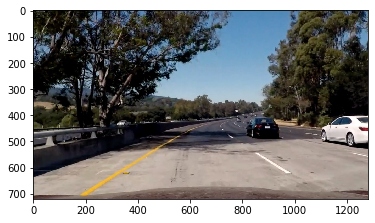

In [485]:
dst = cv2.undistort(img, mtx, dist, None, mtx)
print(dst.shape)
plt.imshow(dst)

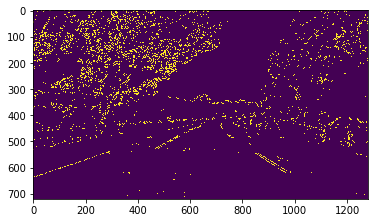

In [486]:
# Thresholding by sobel
# First Gradient absolute value
# Second Gradient magnitude.
# Third Gradient absolute value

def gradient_abs_value_mask(image, orient='x',sobel_kernel=3, threshold=(0, 255)):
    """
    Masks the image based on gradient absolute value.
    Parameters
    ----------
    image           : Image to mask.
    sobel_kernel    : Kernel of the Sobel gradient operation.
    axis            : Axis of the gradient, 'x' or 'y'.
    threshold       : Value threshold for it to make it to appear in the mask.
    Returns
    -------
    Image mask with 1s in activations and 0 in other pixels.
    """
    
    gray_img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # We will use sobel y
    
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray_img, cv2.CV_64F, 1, 0))
    elif orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray_img, cv2.CV_64F, 0, 1))
    
    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Create a copy and apply the threshold
    # Create a mask of 1's where the scaled gradient magnitude is > thresh_min and < thresh_max
    binary_output = np.zeros_like(scaled_sobel)
    
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= threshold[0]) & (scaled_sobel <= threshold[1])] = 1

    return binary_output

def gradient_magnitude_mask(image, sobel_kernel=3, threshold=(0, 255)):
    """
    Masks the image based on gradient magnitude.
    Parameters
    ----------
    image           : Image to mask.
    sobel_kernel    : Kernel of the Sobel gradient operation.
    threshold       : Magnitude threshold for it to make it to appear in the mask.
    Returns
    -------
    Image mask with 1s in activations and 0 in other pixels.
    """
    gray_img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Take the gradient in x and y separately
    sobel_x = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the magnitude
    magnitude = np.sqrt(sobel_x ** 2 + sobel_y ** 2)
    # Scale to 8-bit (0 - 255) and convert to type = np.uint8
    magnitude = (magnitude * 255 / np.max(magnitude)).astype(np.uint8)
    # Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(magnitude)
    binary_output[(magnitude >= threshold[0]) & (magnitude <= threshold[1])] = 1
    # Return this mask as your binary_output image
    return binary_output

def gradient_direction_mask(image, sobel_kernel=3, threshold=(0, np.pi / 2)):
    """
    Masks the image based on gradient direction.
    Parameters
    ----------
    image           : Image to mask.
    sobel_kernel    : Kernel of the Sobel gradient operation.
    threshold       : Direction threshold for it to make it to appear in the mask.
    Returns
    -------
    Image mask with 1s in activations and 0 in other pixels.
    """
    gray_img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Take the gradient in x and y separately
    sobel_x = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the x and y gradients and calculate the direction of the gradient
    direction = np.arctan2(np.absolute(sobel_y), np.absolute(sobel_x))
    # Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(direction)
    # Return this mask as your binary_output image
    binary_output[(direction >= threshold[0]) & (direction <= threshold[1])] = 1
    return binary_output

def apply_threshold(image,ksize=3):
    gradx = gradient_abs_value_mask(image, orient='x', sobel_kernel=ksize, threshold=(20, 100))
    grady = gradient_abs_value_mask(image, orient='y', sobel_kernel=ksize, threshold=(20, 100))
    mag_binary = gradient_magnitude_mask(image, sobel_kernel=ksize, threshold=(30, 100))
    dir_binary = gradient_direction_mask(image, sobel_kernel=ksize, threshold=(0.7, 1.3))

    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

    return combined

combined = apply_threshold(dst)
plt.imshow(combined)

In [487]:
# Color Threshold
def hls_thresh(image, threshold=(170, 255)):
    """
    Convert RGB to HLS and threshold to binary image using S channel
    """
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel >= threshold[0]) & (s_channel <= threshold[1])] = 1
    return binary_output

s_binary = hls_thresh(dst)

In [488]:
def combine_threshold(s_binary, combined):
    combined_binary = np.zeros_like(combined)
    combined_binary[(s_binary == 1) | (combined == 1)] = 1

    return combined_binary

combined_binary = combine_threshold(s_binary, combined)

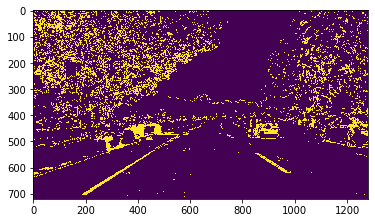

In [489]:
plt.imshow(combined_binary)

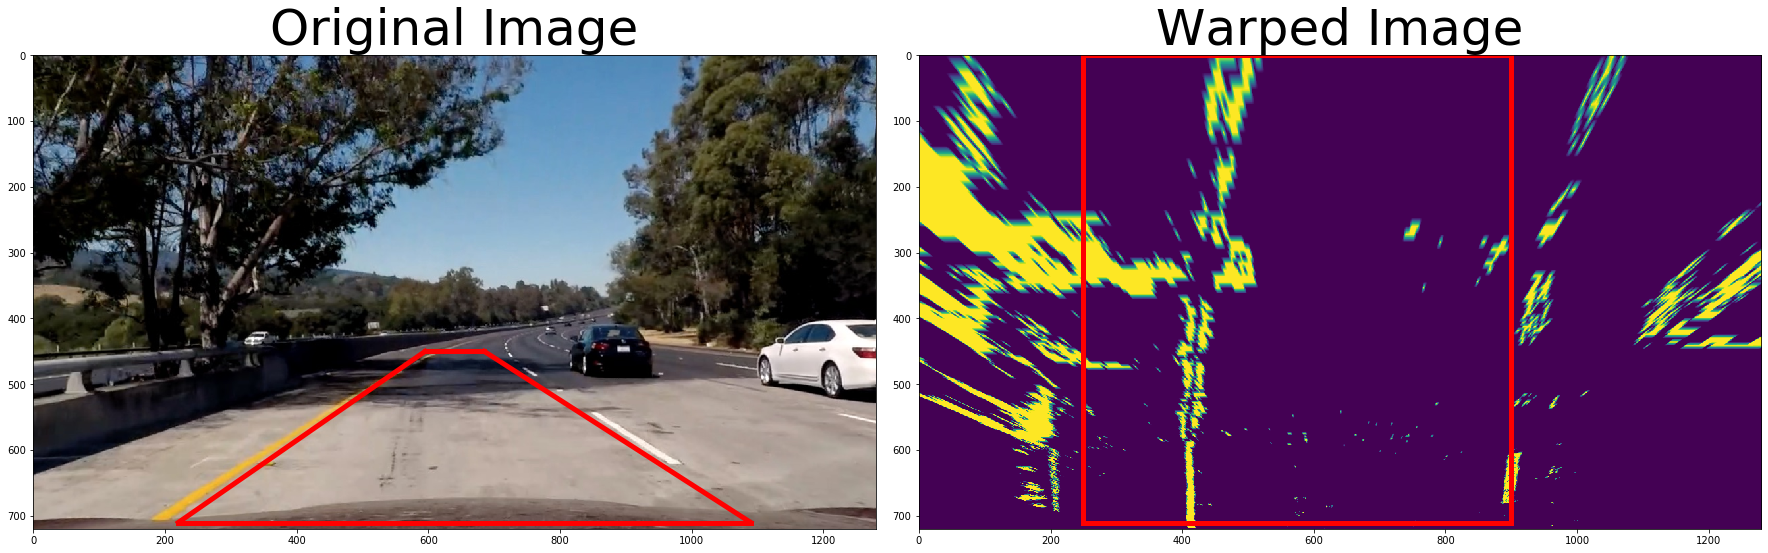

In [490]:
def warp(img):
    img_size = (img.shape[1], img.shape[0])
    x = img.shape[1]
    y = img.shape[0]
    
    src = np.float32(
        [[704, 453],
          [1280, 720],
          [0, 710],
          [576, 453]])

    dst = np.float32(
        [[960, 0],
          [960, 720],
          [320, 720],
          [320, 0]])

#     src = np.float32([
#     [0.117 * x, y],
#     [(0.5 * x) - (x*0.078), (2/3)*y],
#     [(0.5 * x) + (x*0.078), (2/3)*y],
#     [x - (0.117 * x), y]
#     ])
#     dst = np.float32([
#     [0.25 * x, y],
#     [0.25 * x, 0],
#     [x - (0.25 * x), 0],
#     [x - (0.25 * x), y]
#     ])

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

    binary_warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

    return binary_warped, Minv

def compare_plotted_images(image1, image2, image1_exp="Image 1", image2_exp="Image 2"):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image1)
    ax1.plot([685, 1090], [450, 710], color='r', linewidth="5")
    ax1.plot([1090, 220], [710, 710], color='r', linewidth="5")
    ax1.plot([220, 595], [710, 450], color='r', linewidth="5")
    ax1.plot([595, 685], [450, 450], color='r', linewidth="5")
    ax1.set_title(image1_exp, fontsize=50)
    ax2.imshow(image2)
    ax2.plot([900, 900], [0, 710], color='r', linewidth="5")
    ax2.plot([900, 250], [710, 710], color='r', linewidth="5")
    ax2.plot([250, 250], [710, 0], color='r', linewidth="5")
    ax2.plot([250, 900], [0, 0], color='r', linewidth="5")
    ax2.set_title(image2_exp, fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


warped, Minv = warp(combined_binary)
compare_plotted_images(dst, warped, "Original Image", "Warped Image")


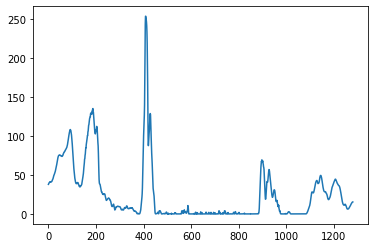

In [491]:
# Histogram
def get_histogram(binary_warped):
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

    return histogram

binary_warped, Minv = warp(dst)
histogram = get_histogram(warped)
plt.plot(histogram)

In [492]:
#Sliding Window
def slide_window(binary_warped, histogram):
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2)
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2)
        
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Visualization Finding the lines
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    # Generate x and y values for plotting
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

    return ploty, left_fit, right_fit

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


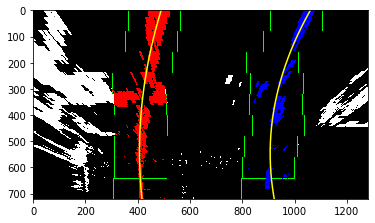

In [493]:
ploty, left_fit, right_fit = slide_window(warped, histogram)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


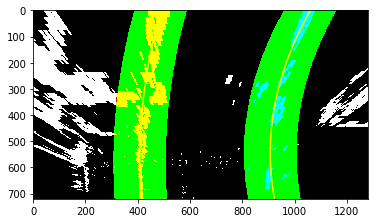

In [494]:
def skip_sliding_window(binary_warped, left_fit, right_fit):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy +
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) +
    left_fit[1]*nonzeroy + left_fit[2] + margin)))

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy +
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) +
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]


    ################################
    ## Visualization
    ################################

    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin,
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin,
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

    ret = {}
    ret['leftx'] = leftx
    ret['rightx'] = rightx
    ret['left_fitx'] = left_fitx
    ret['right_fitx'] = right_fitx
    ret['ploty'] = ploty

    return ret

draw_info = skip_sliding_window(warped, left_fit, right_fit)

In [495]:
def measure_curvature(ploty, lines_info):
    ym_per_pix = 30/720
    xm_per_pix = 3.7/700

    leftx = lines_info['left_fitx']
    rightx = lines_info['right_fitx']

    leftx = leftx[::-1]  
    rightx = rightx[::-1]  

    y_eval = np.max(ploty)
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    print(left_curverad, 'm', right_curverad, 'm')

    return left_curverad, right_curverad

left_curverad, right_curverad = measure_curvature(ploty, draw_info)

688.8066835369433 m 319.7221343803438 m


In [496]:
def draw_lane_lines(img, warped_image, Minv, draw_info):
    leftx = draw_info['leftx']
    rightx = draw_info['rightx']
    left_fitx = draw_info['left_fitx']
    right_fitx = draw_info['right_fitx']
    ploty = draw_info['ploty']

    warp_zero = np.zeros_like(warped_image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0]))
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    

    return result

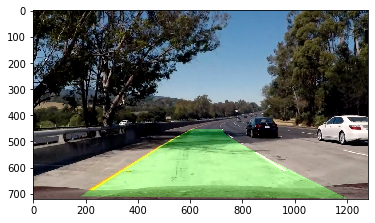

In [497]:

result = draw_lane_lines(img, warped, Minv, draw_info)
plt.imshow(result)